In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
st.norm.ppf(0.9)

1.2815515655446004

## Collect file paths

In [3]:
tycho_gata  = '../data/tycko_gata1_growth.csv'
reilly_gata = '../data/reilly_gata1_flowfish.csv'
doughty_mgg = '../data/doughty_mycgata1_growth.csv'
doughty_gata='../data/doughty_gata1crispri_flowfish.csv'
doughty_cutting = '../data/doughty_gata1cutting_flowfish.csv'

## Set reused shift scale function

This function treats the "Negative Controls" (e.g. non-targeting guides) to zero. And scales the distribution such that purtubing the TSS results in a score in the 80th percentile of effect size increase.

In [4]:
def shift_and_scale_df(in_df, reps=2):
    for i in range(reps):
        rep = i+1
        in_df['log2_shift_rep{}'.format(rep)] = in_df['log2_rep{}'.format(rep)] - in_df.loc[ in_df['guideType'] == 'negative_control', 'log2_rep{}'.format(rep) ].mean()
    
    for i in range(reps):
        rep = i+1
        in_df['log2_shiftScale_rep{}'.format(rep)] = st.norm.ppf(0.9) * in_df['log2_shift_rep{}'.format(rep)] / in_df.loc[ in_df['guideType'] == 'overlap_cage_GATA1', 'log2_shift_rep{}'.format(rep) ].mean()

    return in_df

## Read in files

In [5]:
tycho_data = pd.read_csv(tycho_gata,header=0)
reilly_data = pd.read_csv(reilly_gata,header=0)
doughty_data = pd.read_csv(doughty_gata,header=0)
cutting_data = pd.read_csv(doughty_cutting,header=0)
mgg_data = pd.read_csv(doughty_mgg,header=0)


## Tycho data

Checking dataframe columns, targeted chromosomes, guideTypes, total read depth.

In [6]:
tycho_data.columns

Index(['chrPerturbationTarget', 'startPerturbationTarget',
       'endPerturbationTarget', 'chrTSS', 'startTSS', 'endTSS', 'name',
       'EffectSize', 'strandElement', 'strandGene', 'CellType', 'GeneSymbol',
       'EnsemblID', 'GenomeBuild', 'guideSequence', 'guideID',
       'guidescanCuttingEfficiencyScore', 'guidescanCuttingSpecificityScore',
       'offtargetsSum', 'EnrichmentRep1', 'StartCountsRep1', 'T14CountsRep1',
       'EnrichmentRep2', 'StartCountsRep2', 'T14CountsRep2', 'guideType'],
      dtype='object')

In [7]:
tycho_data['chrPerturbationTarget'].unique()

array(['chrX', 'chr3', 'chr9', 'chr5', 'chr8', 'chr7', 'chr13', 'chr11',
       'chr4', 'chr2', 'chr15', 'chr10', 'chr18', 'chr6', 'chr12',
       'chr14', 'chr21', 'chr1', 'chr17', 'chr16', 'chr19'], dtype=object)

In [8]:
tycho_data['guideType'].unique()

array(['tiling', 'overlap_cage_GATA1', 'negative_control'], dtype=object)

In [9]:
print('Rep1 counts: {}'.format(tycho_data['T14CountsRep1'].sum()))
print('Rep2 counts: {}'.format(tycho_data['T14CountsRep2'].sum()))

Rep1 counts: 2385445.0
Rep2 counts: 2392873.0


Setting raw log2 effect, then normalizing

In [10]:
tycho_data['log2_rep1'] = -1 * np.log2((tycho_data['T14CountsRep1']+1) / (tycho_data['StartCountsRep1']+1))
tycho_data['log2_rep2'] = -1 * np.log2((tycho_data['T14CountsRep2']+1) / (tycho_data['StartCountsRep2']+1))


In [11]:
tycho_data = shift_and_scale_df(tycho_data)

checking that shift-scaling worked as planned

In [12]:
print(tycho_data.loc[ tycho_data['guideType'] == 'overlap_cage_GATA1', 'log2_shift_rep1' ].mean())
print(tycho_data.loc[ tycho_data['guideType'] == 'overlap_cage_GATA1', 'log2_shiftScale_rep1' ].mean())

1.6054040442789372
1.2815515655446004


write to file

In [13]:
tycho_data.to_csv("../data/log2_scores/{}".format(os.path.basename(tycho_gata)),header=True,index=False)

## Reilly data

checking stuff again

In [14]:
reilly_data['guideType'].unique()

array(['tiling', 'overlap_cage_GATA1', 'negative_control'], dtype=object)

In [15]:
print('Rep1 low  expression counts: {}'.format(reilly_data['LS_reads_rep1'].sum()))
print('Rep1 high expression counts: {}'.format(reilly_data['HS_reads_rep1'].sum()))
print('Rep2 low  expression counts: {}'.format(reilly_data['LS_reads_rep2'].sum()))
print('Rep2 high expression counts: {}'.format(reilly_data['HS_reads_rep2'].sum()))


Rep1 low  expression counts: 9533664
Rep1 high expression counts: 8547503
Rep2 low  expression counts: 9110392
Rep2 high expression counts: 6666985


Calculating various versions of effect size and checking

In [16]:
reilly_data['log2_rep1'] = np.log2((reilly_data['LS_reads_rep1']+1) / (reilly_data['HS_reads_rep1']+1))
reilly_data['log2_rep2'] = np.log2((reilly_data['LS_reads_rep2']+1) / (reilly_data['HS_reads_rep2']+1))

reilly_data = shift_and_scale_df(reilly_data)

print(reilly_data.loc[ reilly_data['guideType'] == 'overlap_cage_GATA1', 'log2_shift_rep1' ].mean())

print(reilly_data.loc[ reilly_data['guideType'] == 'overlap_cage_GATA1', 'log2_shiftScale_rep1' ].mean())


6.326273544901742
1.2815515655446001


In [17]:
reilly_data.to_csv("../data/log2_scores/{}".format(os.path.basename(reilly_gata)),header=True,index=False)

## Doughty data (GATA1 FlowFISH)

In [18]:
for rep in range(3):
    for abin in range(6):
        for pcr in range(3):
            my_rep = rep + 1
            my_abin= abin + 1
            my_pcr = pcr + 1
            doughty_data['rep{}_bin{}_pcr{}_counts'.format(my_rep,my_abin,my_pcr)] = pd.to_numeric(doughty_data['rep{}_bin{}_pcr{}_counts'.format(my_rep,my_abin,my_pcr)].replace('.',0))
            


In [19]:
doughty_data['log2_rep1'] = np.log2( (doughty_data[['rep1_bin1_pcr1_counts','rep1_bin1_pcr2_counts','rep1_bin1_pcr3_counts']].sum(1) + 1) / \
                                     (doughty_data[['rep1_bin6_pcr1_counts','rep1_bin6_pcr2_counts','rep1_bin6_pcr3_counts']].sum(1) + 1)
                                   )

doughty_data['log2_rep2'] = np.log2( (doughty_data[['rep2_bin1_pcr1_counts','rep2_bin1_pcr2_counts','rep2_bin1_pcr3_counts']].sum(1) + 1) / \
                                     (doughty_data[['rep2_bin6_pcr1_counts','rep2_bin6_pcr2_counts','rep2_bin6_pcr3_counts']].sum(1) + 1)
                                   )

doughty_data['log2_rep3'] = np.log2( (doughty_data[['rep3_bin1_pcr1_counts','rep3_bin1_pcr2_counts','rep3_bin1_pcr3_counts']].sum(1) + 1) / \
                                     (doughty_data[['rep3_bin6_pcr1_counts','rep3_bin6_pcr2_counts','rep3_bin6_pcr3_counts']].sum(1) + 1)
                                   )


In [20]:
doughty_data = shift_and_scale_df(doughty_data,3)

print(doughty_data.loc[ doughty_data['guideType'] == 'overlap_cage_GATA1', 'log2_shift_rep1' ].mean())

print(doughty_data.loc[ doughty_data['guideType'] == 'overlap_cage_GATA1', 'log2_shiftScale_rep1' ].mean())


4.5816618637447135
1.2815515655446004


In [21]:
doughty_data.to_csv("../data/log2_scores/{}".format(os.path.basename(doughty_gata)),header=True,index=False)

## Doughty data (GATA cutting)

In [22]:
cutting_data

,chrPerturbationTarget,startPerturbationTarget,endPerturbationTarget,chrTSS,startTSS,endTSS,name,EffectSize,strandElement,strandGene,...,rep2_bin4_pcr4_counts,rep2_bin5_pcr1_counts,rep2_bin5_pcr2_counts,rep2_bin5_pcr3_counts,rep2_bin5_pcr4_counts,rep2_bin6_pcr1_counts,rep2_bin6_pcr2_counts,rep2_bin6_pcr3_counts,rep2_bin6_pcr4_counts,guideType
0,chr8,129113248,129113268,chrX,48644962,48644962,chr8:129113248.0-129113268.0:-,.,-,+,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tiling
1,chrX,48654347,48654367,chrX,48644962,48644962,chrX:48654347.0-48654367.0:+,.,+,+,...,31.0,21.0,38.0,4.0,29.0,11.0,29.0,29.0,41.0,tiling
2,chrX,48632828,48632848,chrX,48644962,48644962,chrX:48632828.0-48632848.0:+,.,+,+,...,38.0,23.0,51.0,11.0,35.0,24.0,29.0,26.0,53.0,tiling
3,chrX,48652413,48652433,chrX,48644962,48644962,chrX:48652413.0-48652433.0:-,.,-,+,...,8.0,22.0,21.0,6.0,22.0,5.0,20.0,7.0,18.0,tiling
4,chrX,48380686,48380706,chrX,48644962,48644962,chrX:48380686.0-48380706.0:+,.,+,+,...,127.0,101.0,254.0,28.0,124.0,63.0,106.0,102.0,126.0,tiling
5,chr8,129001742,129001762,chrX,48644962,48644962,chr8:129001742.0-129001762.0:+,.,+,+,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tiling
6,chrX,48654161,48654181,chrX,48644962,48644962,chrX:48654161.0-48654181.0:+,.,+,+,...,56.0,56.0,218.0,48.0,48.0,71.0,71.0,44.0,92.0,tiling
7,chr1,161436369,161436389,.,.,.,chr1:161436369.0-161436389.0:-,.,-,+,...,25.0,20.0,31.0,2.0,25.0,21.0,32.0,11.0,37.0,negative_control
8,chr1,161428983,161429003,.,.,.,chr1:161428983.0-161429003.0:-,.,-,+,...,25.0,20.0,31.0,2.0,25.0,21.0,32.0,11.0,37.0,negative_control
9,chr8,129089058,129089078,chrX,48644962,48644962,chr8:129089058.0-129089078.0:-,.,-,+,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tiling


In [23]:
for rep in range(2):
    for abin in range(6):
        for pcr in range(3):
            my_rep = rep + 1
            my_abin= abin + 1
            my_pcr = pcr + 1
            cutting_data['rep{}_bin{}_pcr{}_counts'.format(my_rep,my_abin,my_pcr)] = pd.to_numeric(cutting_data['rep{}_bin{}_pcr{}_counts'.format(my_rep,my_abin,my_pcr)].replace('.',0))


In [24]:
cutting_data['log2_rep1'] = np.log2( (cutting_data[['rep1_bin1_pcr1_counts','rep1_bin1_pcr2_counts','rep1_bin1_pcr3_counts']].sum(1) + 1) / \
                                     (cutting_data[['rep1_bin6_pcr1_counts','rep1_bin6_pcr2_counts','rep1_bin6_pcr3_counts']].sum(1) + 1)
                                   )

cutting_data['log2_rep2'] = np.log2( (cutting_data[['rep2_bin1_pcr1_counts','rep2_bin1_pcr2_counts','rep2_bin1_pcr3_counts']].sum(1) + 1) / \
                                     (cutting_data[['rep2_bin6_pcr1_counts','rep2_bin6_pcr2_counts','rep2_bin6_pcr3_counts']].sum(1) + 1)
                                   )



In [25]:
cutting_data = shift_and_scale_df(cutting_data,2)

print(cutting_data.loc[ cutting_data['guideType'] == 'overlap_cage_GATA1', 'log2_shift_rep1' ].mean())

print(cutting_data.loc[ cutting_data['guideType'] == 'overlap_cage_GATA1', 'log2_shiftScale_rep1' ].mean())


0.7507069869437736
1.2815515655446001


In [26]:
cutting_data.to_csv("../data/log2_scores/{}".format(os.path.basename(doughty_cutting)),header=True,index=False)

## Doughty data (GATA MYC growth)

In [27]:
mgg_data

,chrPerturbationTarget,startPerturbationTarget,endPerturbationTarget,chrTSS,startTSS,endTSS,name,EffectSize,strandElement,strandGene,...,EnsemblID,GenomeBuild,guideSequence,guideID,OffTargetScore,Rep1_T0,Rep1_Tend,Rep2_T0,Rep2_Tend,guideType
0,chr8,128181414,128181434,chr8,128747680,128747680,chr8:128181414-128181434:+,.,+,+,...,ENSG00000136997.10,hg19,GTCTCCTCTTGCCAAAGCGTG,151002_180K_Arrays-150003,89,103,75,127,258,tiling
1,chr8,128935943,128935963,chr8,128747680,128747680,chr8:128935943-128935963:-,.,-,+,...,ENSG00000136997.10,hg19,GTCTCCTCTTCCCAGCTCCCG,151002_180K_Arrays-150002,56,253,505,403,673,tiling
2,chr8,128852562,128852582,chr8,128747680,128747680,chr8:128852562-128852582:-,.,-,+,...,ENSG00000136997.10,hg19,GTCTCCTCTGAAGACATTGG,151002_180K_Arrays-150001,79,261,260,253,283,tiling
3,chrX,48650709,48650729,chrX,48644962,48644962,chrX:48650709-48650729:+,.,+,+,...,ENSG00000102145.9,hg19,GTCTCCTCTCCACCCCACCAG,151002_180K_Arrays-150000,55,254,102,227,237,overlap_cage_GATA1
4,chr8,129447597,129447617,chr8,128747680,128747680,chr8:129447597-129447617:+,.,+,+,...,ENSG00000136997.10,hg19,GTCTCCTGAATACGTAAGTAC,151002_180K_Arrays-150007,90,436,628,570,438,tiling
5,chr8,128842675,128842695,chr8,128747680,128747680,chr8:128842675-128842695:-,.,-,+,...,ENSG00000136997.10,hg19,GTCTCCTGAAATAAAGCAATA,151002_180K_Arrays-150006,70,133,246,189,261,tiling
6,chr8,128932261,128932281,chr8,128747680,128747680,chr8:128932261-128932281:+,.,+,+,...,ENSG00000136997.10,hg19,GTCTCCTCTTGTCCCCAACAG,151002_180K_Arrays-150004,77,403,355,426,312,tiling
7,chr8,130706149,130706169,chr8,128747680,128747680,chr8:130706149-130706169:-,.,-,+,...,ENSG00000136997.10,hg19,GGAAAAAAAACCAGGCAAAA,151002_180K_Arrays-112987,42,153,207,215,231,tiling
8,chrX,48650139,48650159,chrX,48644962,48644962,chrX:48650139-48650159:+,.,+,+,...,ENSG00000102145.9,hg19,GTGGGAACTTGGCCACCATGT,151002_180K_Arrays-161986,77,240,362,269,223,tiling
9,chr8,129437518,129437538,chr8,128747680,128747680,chr8:129437518-129437538:-,.,-,+,...,ENSG00000136997.10,hg19,GTGGGAAGAAAACTGGATTAA,151002_180K_Arrays-161987,64,308,152,241,549,tiling


In [28]:
mgg_data['guideType'].unique()

array(['tiling', 'overlap_cage_GATA1', 'negative_control',
       'overlap_cage_MYC'], dtype=object)

In [29]:
mgg_data['log2_rep1'] = -1 * np.log2((mgg_data['Rep1_Tend']+1) / (mgg_data['Rep1_T0']+1))
mgg_data['log2_rep2'] = -1 * np.log2((mgg_data['Rep2_Tend']+1) / (mgg_data['Rep2_T0']+1))

mgg_data['log2_shift_rep1'] = mgg_data['log2_rep1'] - mgg_data.loc[ mgg_data['guideType'] == 'negative_control', 'log2_rep1' ].mean()
mgg_data['log2_shift_rep2'] = mgg_data['log2_rep2'] - mgg_data.loc[ mgg_data['guideType'] == 'negative_control', 'log2_rep2' ].mean()

print(mgg_data.loc[ mgg_data['guideType'] == 'overlap_cage_GATA1', 'log2_shift_rep1' ].mean())

mgg_data['log2_shiftScale_rep1'] = st.norm.ppf(0.9) * mgg_data['log2_shift_rep1'] / mgg_data.loc[ mgg_data['guideType'] == 'overlap_cage_GATA1', 'log2_shift_rep1' ].mean()
mgg_data['log2_shiftScale_rep2'] = st.norm.ppf(0.9) * mgg_data['log2_shift_rep2'] / mgg_data.loc[ mgg_data['guideType'] == 'overlap_cage_GATA1', 'log2_shift_rep2' ].mean()
mgg_data.loc[mgg_data['chrTSS']=='chr8','log2_shiftScale_rep1'] = st.norm.ppf(0.9) * mgg_data.loc[mgg_data['chrTSS']=='chr8','log2_shift_rep1'] / mgg_data.loc[ mgg_data['guideType'] == 'overlap_cage_MYC', 'log2_shift_rep1' ].mean()
mgg_data.loc[mgg_data['chrTSS']=='chr8','log2_shiftScale_rep2'] = st.norm.ppf(0.9) * mgg_data.loc[mgg_data['chrTSS']=='chr8','log2_shift_rep2'] / mgg_data.loc[ mgg_data['guideType'] == 'overlap_cage_MYC', 'log2_shift_rep2' ].mean()

print(mgg_data.loc[ mgg_data['guideType'] == 'overlap_cage_GATA1', 'log2_shiftScale_rep1' ].mean())


1.9048608919282426
1.2815515655446001


In [30]:
print(mgg_data.loc[ mgg_data['guideType'] == 'overlap_cage_GATA1', 'log2_rep1' ].mean())
print(mgg_data.loc[ mgg_data['guideType'] == 'overlap_cage_MYC', 'log2_rep1' ].mean())

print(mgg_data.loc[ mgg_data['guideType'] == 'overlap_cage_GATA1', 'log2_shift_rep1' ].mean())
print(mgg_data.loc[ mgg_data['guideType'] == 'overlap_cage_MYC', 'log2_shift_rep1' ].mean())

print(mgg_data.loc[ mgg_data['guideType'] == 'overlap_cage_GATA1', 'log2_shiftScale_rep1' ].mean())
print(mgg_data.loc[ mgg_data['guideType'] == 'overlap_cage_MYC', 'log2_shiftScale_rep1' ].mean())

1.8403193226701284
0.30175020698257193
1.9048608919282426
0.36629177624068543
1.2815515655446001
1.2815515655446001


In [31]:
mgg_data.to_csv("../data/log2_scores/{}".format(os.path.basename(doughty_mgg)),header=True,index=False)

In [32]:
"../data/log2_scores/{}".format(os.path.basename(doughty_mgg))

'../data/log2_scores/doughty_mycgata1_growth.csv'

## Distribution checks

In [33]:
tycho_data
reilly_data
doughty_data
cutting_data
mgg_data


,chrPerturbationTarget,startPerturbationTarget,endPerturbationTarget,chrTSS,startTSS,endTSS,name,EffectSize,strandElement,strandGene,...,Rep1_Tend,Rep2_T0,Rep2_Tend,guideType,log2_rep1,log2_rep2,log2_shift_rep1,log2_shift_rep2,log2_shiftScale_rep1,log2_shiftScale_rep2
0,chr8,128181414,128181434,chr8,128747680,128747680,chr8:128181414-128181434:+,.,+,+,...,75,127,258,tiling,0.452512,-1.016808,0.517054,-1.051198,1.809025,-3.629770
1,chr8,128935943,128935963,chr8,128747680,128747680,chr8:128935943-128935963:-,.,-,+,...,505,403,673,tiling,-0.994309,-0.738393,-0.929767,-0.772783,-3.252993,-2.668408
2,chr8,128852562,128852582,chr8,128747680,128747680,chr8:128852562-128852582:-,.,-,+,...,260,253,283,tiling,0.005517,-0.161062,0.070059,-0.195453,0.245115,-0.674894
3,chrX,48650709,48650729,chrX,48644962,48644962,chrX:48650709-48650729:+,.,+,+,...,102,227,237,overlap_cage_GATA1,1.307853,-0.061928,1.372394,-0.096318,0.923319,-0.070004
4,chr8,129447597,129447617,chr8,128747680,128747680,chr8:129447597-129447617:+,.,+,+,...,628,570,438,tiling,-0.525427,0.379270,-0.460885,0.344880,-1.612507,1.190864
5,chr8,128842675,128842695,chr8,128747680,128747680,chr8:128842675-128842695:-,.,-,+,...,246,189,261,tiling,-0.882278,-0.463567,-0.817736,-0.497958,-2.861029,-1.719439
6,chr8,128932261,128932281,chr8,128747680,128747680,chr8:128932261-128932281:+,.,+,+,...,355,426,312,tiling,0.182478,0.448073,0.247020,0.413683,0.864252,1.428441
7,chr8,130706149,130706169,chr8,128747680,128747680,chr8:130706149-130706169:-,.,-,+,...,207,215,231,tiling,-0.433653,-0.103093,-0.369112,-0.137484,-1.291417,-0.474729
8,chrX,48650139,48650159,chrX,48644962,48644962,chrX:48650139-48650159:+,.,+,+,...,362,269,223,tiling,-0.590936,0.269461,-0.526395,0.235071,-0.354148,0.170849
9,chr8,129437518,129437538,chr8,128747680,128747680,chr8:129437518-129437538:-,.,-,+,...,152,241,549,tiling,1.014075,-1.184425,1.078617,-1.218815,3.773776,-4.208546


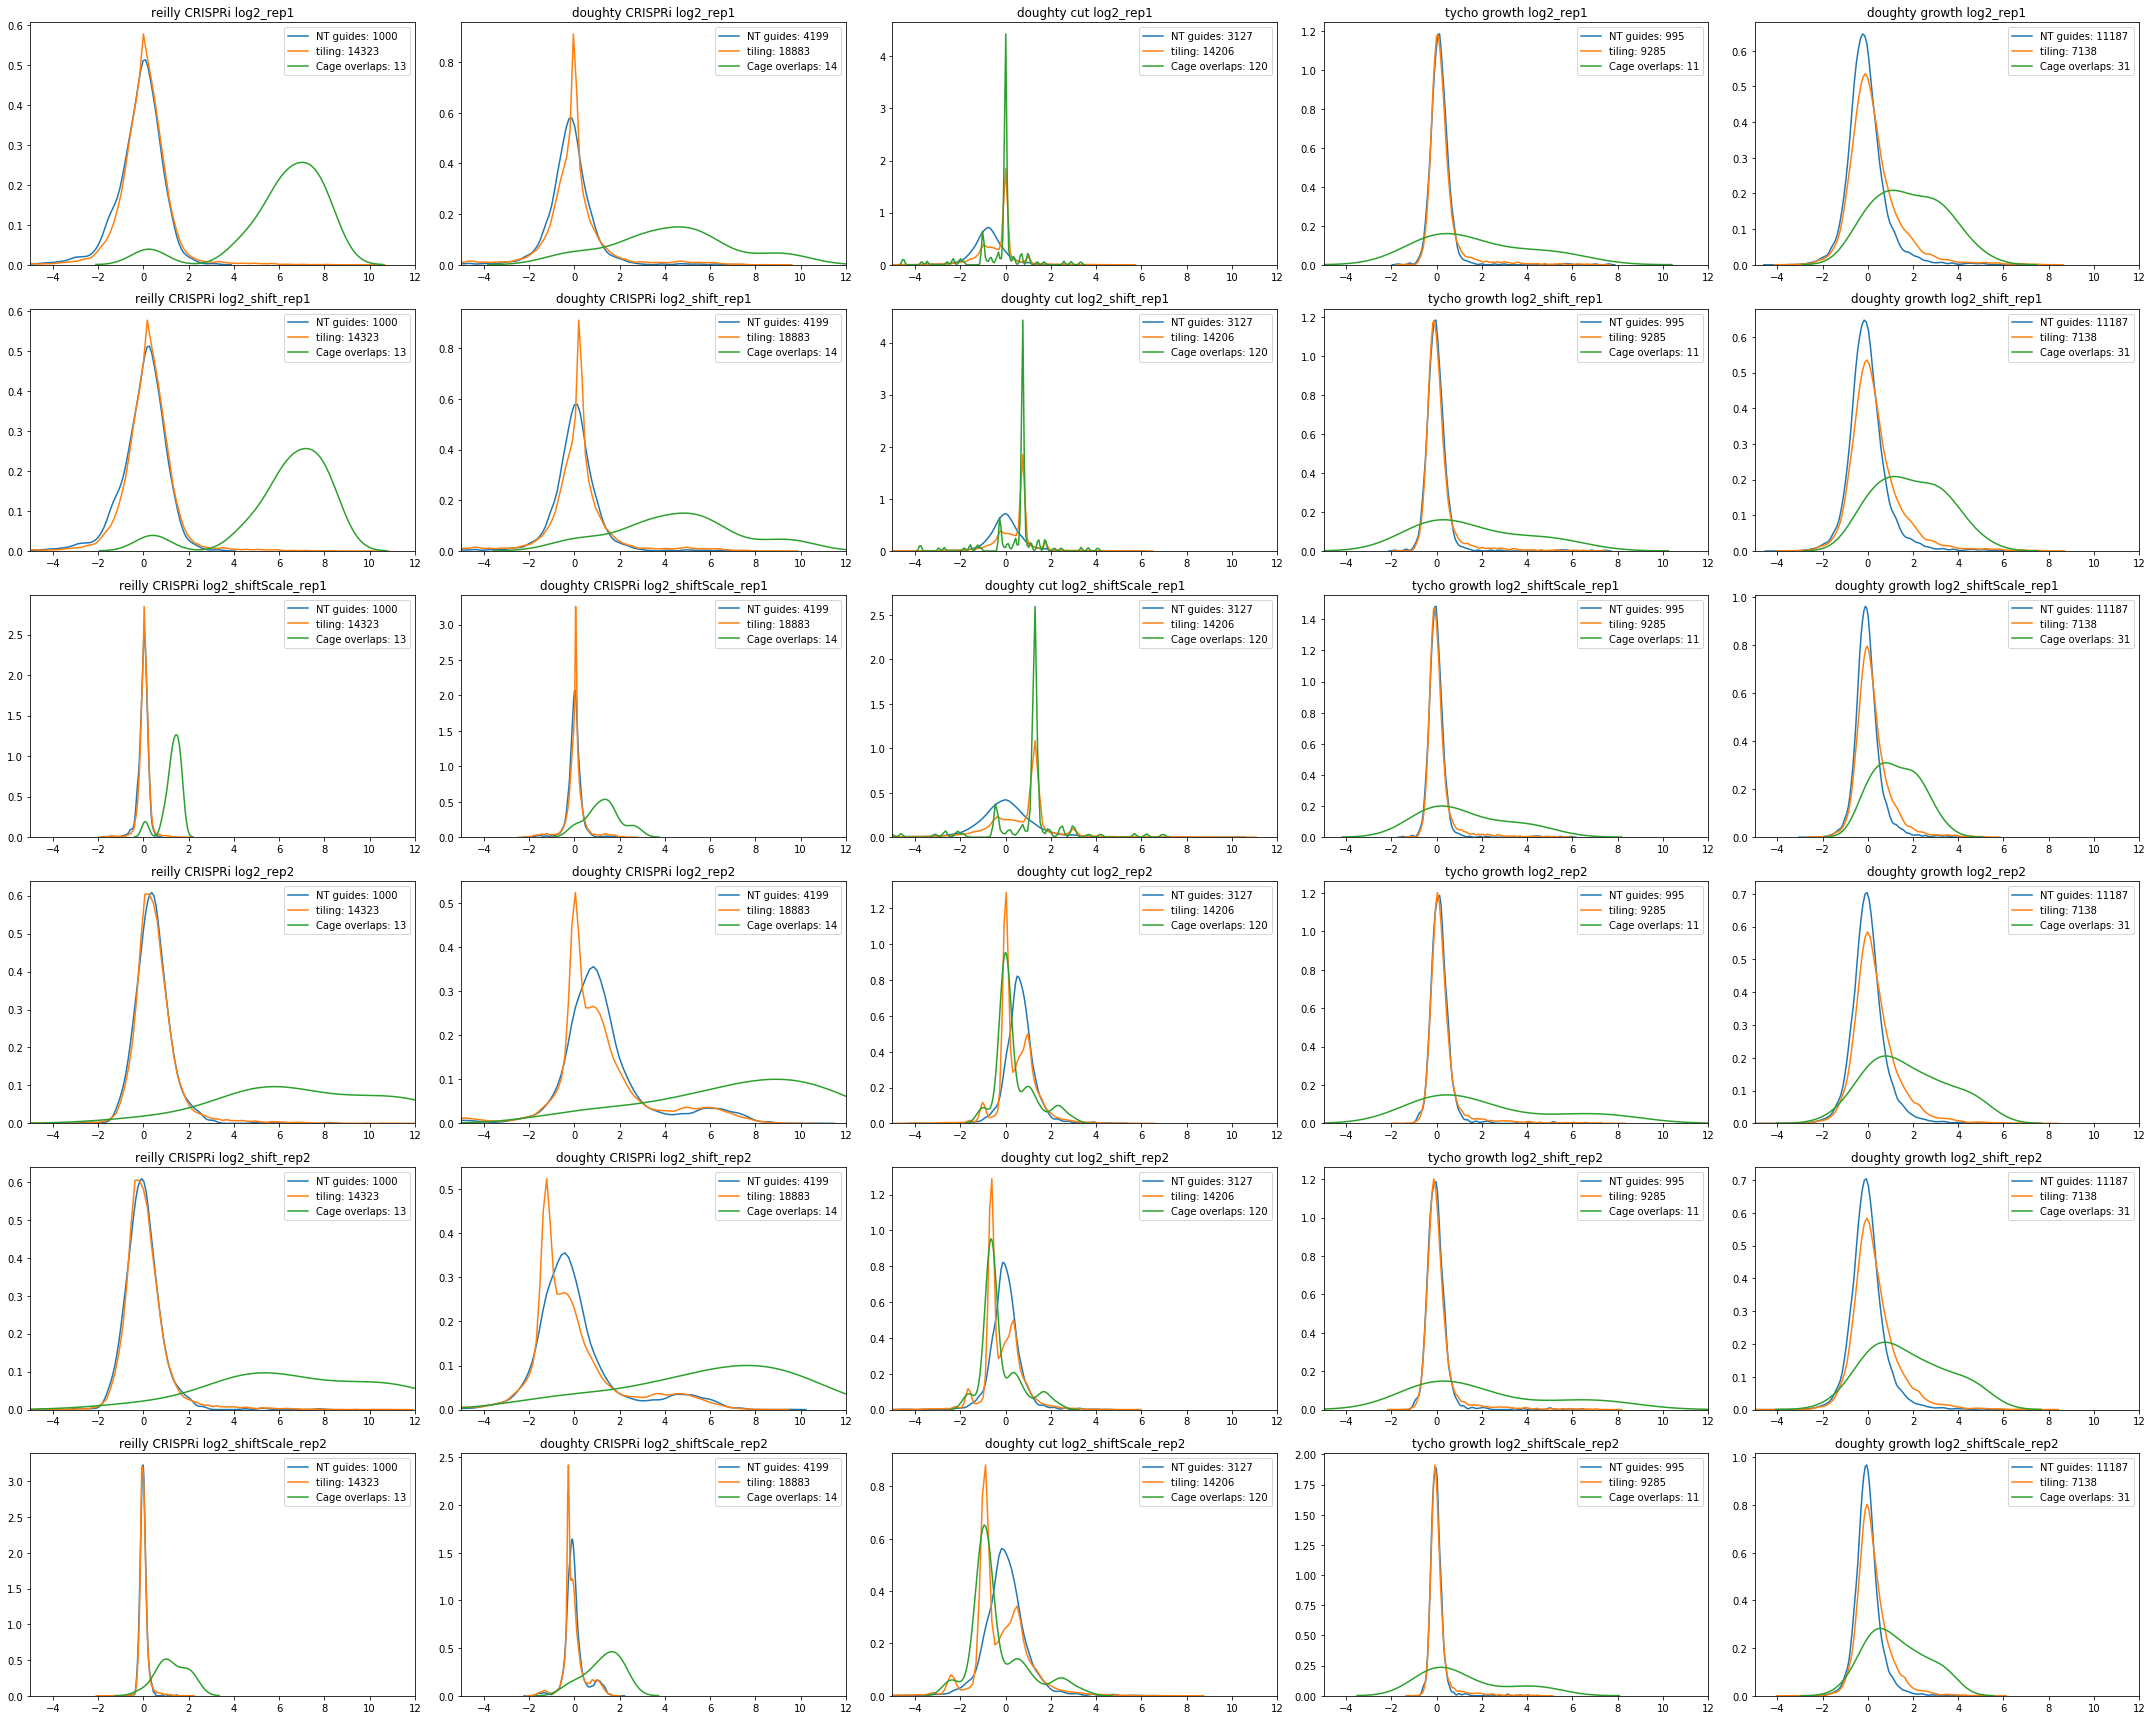

In [37]:
fig = plt.figure(figsize=(30,24))
hold_ax = []
ax_idx = 0
for rep in range(2):
    for i,kind in enumerate(['log2_rep{}','log2_shift_rep{}','log2_shiftScale_rep{}']):
        for j,data_ in enumerate([reilly_data, doughty_data, cutting_data, tycho_data, mgg_data[~mgg_data['chrTSS'].str.contains('chr8')]]):
        #for j,data_ in enumerate([reilly_data, doughty_data, cutting_data, tycho_data, mgg_data[~mgg_data['chrTSS'].str.contains('chrX')]]):
        #for j,data_ in enumerate([reilly_data, doughty_data, cutting_data, tycho_data, mgg_data]):
            ax_idx += 1
            if ax_idx <= 5:
                ax = plt.subplot(6,5,ax_idx)
                ax.set_xlim(-5,12)
                hold_ax.append(ax)
            else:
                ax = plt.subplot(6,5,ax_idx,sharex=hold_ax[j])
            grab = kind.format(rep+1)
            NT_data = data_.loc[data_['guideType'].str.contains('negative_control'),grab]
            TL_data = data_.loc[data_['guideType'].str.contains('tiling'),grab]
            PC_data = data_.loc[data_['guideType'].str.contains('overlap_cage'),grab]
            sns.kdeplot(NT_data, label='NT guides: {}'.format(NT_data.shape[0]))
            sns.kdeplot(TL_data, label='tiling: {}'.format(TL_data.shape[0]))
            sns.kdeplot(PC_data, label='Cage overlaps: {}'.format(PC_data.shape[0]))
            tags = ['reilly CRISPRi','doughty CRISPRi','doughty cut','tycho growth','doughty growth']
            ax.set_title('{} {}'.format(tags[j],grab))
                        
plt.tight_layout()
plt.savefig('log2_score_dists.pdf')
plt.show()


In [ ]:
fig = plt.figure(figsize=(10,8))


ax1 = plt.subplot(2,2,1)
sns.kdeplot( log2_rep1_raw[NT_flag], label='NT guides' )
sns.kdeplot( log2_rep1_raw[~NT_flag], label='Targ guides' )
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(2,2,3, sharex=ax1)
sns.kdeplot( log2_rep1_rpkm[NT_flag] )
sns.kdeplot( log2_rep1_rpkm[~NT_flag])

ax1.set_title('rep1')

ax3 = plt.subplot(2,2,2)
sns.kdeplot( log2_rep1_raw[NT_flag], label='NT guides' )
sns.kdeplot( log2_rep1_raw[~NT_flag], label='Targ guides' )
plt.setp(ax1.get_xticklabels(), visible=False)

ax4 = plt.subplot(2,2,4, sharex=ax3)
sns.kdeplot( log2_rep1_rpkm[NT_flag] )
sns.kdeplot( log2_rep1_rpkm[~NT_flag])

ax3.set_title('rep2')

plt.title('log2 enrichment distribution')
plt.show()


## Crap code below

In [10]:
rand_slice = np.random.choice([True,False],size=len(log2_rep1_raw),replace=True,p=[0.05,0.95])
cat_data = pd.DataFrame( np.stack([log2_rep1_raw,
                                   log2_rep1_rpkm,
                                   log2_rep2_raw,
                                   log2_rep2_rpkm,
                                   ['NT' if x else 'Targ' for x in NT_flag]]
                                 ).T,
                         columns=['rep1_raw','rep1_rpkm','rep2_raw','rep2_rpkm','type']
                       )


In [11]:
cat_data[rand_slice]

,rep1_raw,rep1_rpkm,rep2_raw,rep2_rpkm,type
30,0.5284093605558807,0.366557062898541,0.8530567803637595,0.39807153321647476,Targ
33,0.16262969926392074,0.00508568731106831,0.11351912399550577,-0.33373283100037643,Targ
49,0.6590701824983691,0.4936454864645327,0.18383257480540757,-0.2616627972073186,Targ
134,-1.5641289973039905,-1.671749739264786,-0.4484062488640122,-0.884057887985621,Targ
172,-1.040440926028497,-1.1725590288637386,0.18036674816395923,-0.265331355587509,Targ
221,0.9149442300472274,0.744857131053233,-0.009218530029378664,-0.4484160554372763,Targ
244,3.2902192351600243,2.7366878794325893,2.384663850235325,1.6130984245510605,Targ
246,0.3954496939094456,0.23413422252485136,0.019853914808633317,-0.4229663497337289,Targ
272,0.4653808849684836,0.30130483254149604,-0.3310111996498008,-0.7672232718946537,Targ
343,-1.2815703572712214,-1.3681864726494457,0.1740293997750489,-0.2600478908117492,Targ


In [16]:
cat_data[rand_slice].iloc[:,0:4].max(0)

rep1_raw     8.047554
rep1_rpkm    7.356851
rep2_raw     8.517997
rep2_rpkm    8.020271
dtype: float64

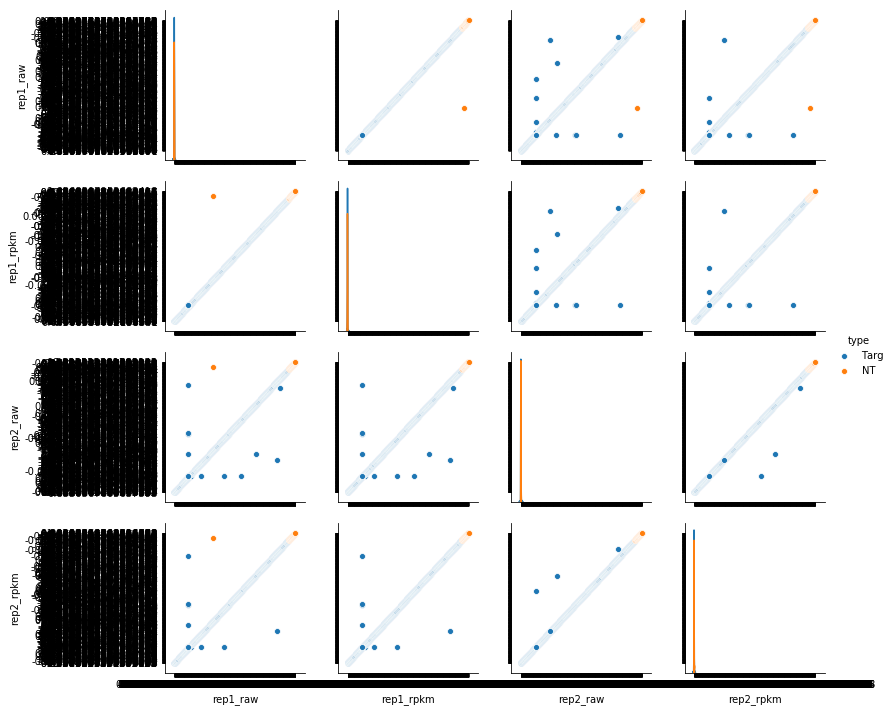

In [12]:
sns.pairplot(cat_data[rand_slice],hue='type')

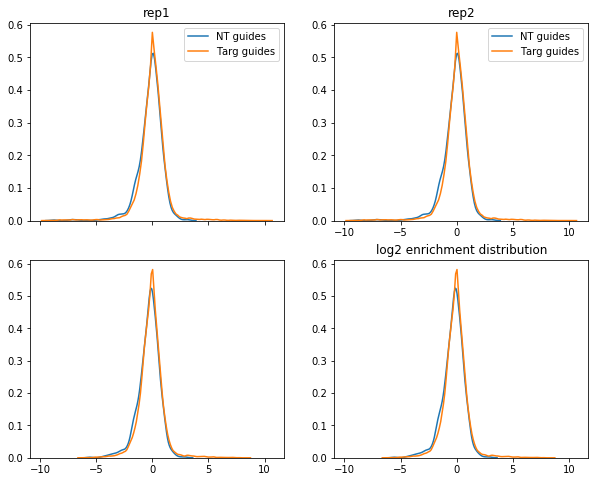

In [13]:
fig = plt.figure(figsize=(10,8))


ax1 = plt.subplot(2,2,1)
sns.kdeplot( log2_rep1_raw[NT_flag], label='NT guides' )
sns.kdeplot( log2_rep1_raw[~NT_flag], label='Targ guides' )
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = plt.subplot(2,2,3, sharex=ax1)
sns.kdeplot( log2_rep1_rpkm[NT_flag] )
sns.kdeplot( log2_rep1_rpkm[~NT_flag])

ax1.set_title('rep1')

ax3 = plt.subplot(2,2,2)
sns.kdeplot( log2_rep1_raw[NT_flag], label='NT guides' )
sns.kdeplot( log2_rep1_raw[~NT_flag], label='Targ guides' )
plt.setp(ax1.get_xticklabels(), visible=False)

ax4 = plt.subplot(2,2,4, sharex=ax3)
sns.kdeplot( log2_rep1_rpkm[NT_flag] )
sns.kdeplot( log2_rep1_rpkm[~NT_flag])

ax3.set_title('rep2')

plt.title('log2 enrichment distribution')
plt.show()


In [ ]:
non_rpkm[ reilly_data['chrPerturbationTarget'] != 'NaN' ]

In [ ]:
reilly_data['log2_rep1'] = np.log2(reilly_data['LS_reads_rep1'])

In [ ]:
doughty_data